In [1]:
#dataset @ https://finance.yahoo.com/quote/GTMEY/history?period1=1633824000&period2=1665360000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

import pandas as pd
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
import pandas as pd
df=pd.read_csv('GTMEY.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-12,41.970001,41.970001,41.970001,41.970001,38.053997,0
1,2020-10-13,41.970001,41.970001,41.970001,41.970001,38.053997,0
2,2020-10-14,40.430000,40.430000,40.430000,40.430000,36.657692,500
3,2020-10-15,40.430000,40.430000,40.430000,40.430000,36.657692,0
4,2020-10-16,40.430000,40.430000,40.430000,40.430000,36.657692,0
...,...,...,...,...,...,...,...
498,2022-10-04,42.000000,42.000000,42.000000,42.000000,42.000000,0
499,2022-10-05,42.000000,42.000000,42.000000,42.000000,42.000000,0
500,2022-10-06,42.000000,42.000000,42.000000,42.000000,42.000000,0
501,2022-10-07,42.000000,42.000000,42.000000,42.000000,42.000000,0


<AxesSubplot:>

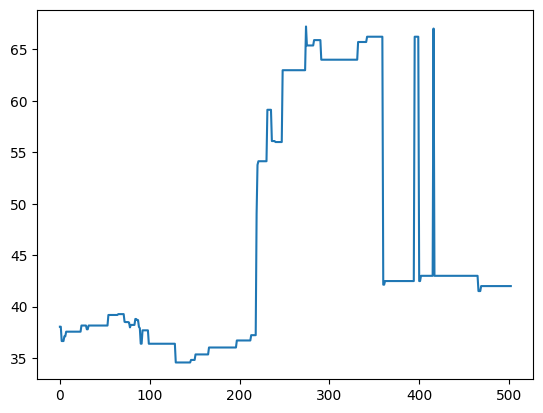

In [3]:
y_gtmey = df['Adj Close']
y_gtmey.index=df.index
y_gtmey.plot()

In [4]:
y_gtmey = y_gtmey.values

In [5]:
training_size = int(y_gtmey.size * 0.8)
print(training_size)

402


In [6]:
training_mean = y_gtmey[:training_size].mean()
training_std = y_gtmey[:training_size].std()
# standarize the data
y_gtmey = (y_gtmey-training_mean)/training_std

In [7]:
y_gtmey[0:5]

array([-0.70761928, -0.70761928, -0.82000228, -0.82000228, -0.82000228])

In [8]:
def data_preprocess(dataset, iStart, iEnd, sHistory):
  data = []
  target = []
  # begin with sHistory to have historical data
  iStart += sHistory
  if iEnd is None:
    iEnd = len(dataset)
  for i in range(iStart, iEnd):
    indices = range(i-sHistory, i)
    data.append(np.reshape(dataset[indices], (sHistory, 1)))
    target.append(dataset[i])
  return np.array(data), np.array(target)

In [9]:
past_history = 10
xtrain, ytrain = data_preprocess(y_gtmey, 0, training_size, past_history)
xtest, ytest = data_preprocess(y_gtmey, training_size, None, past_history)

In [10]:
xtest[0]

array([[-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227]])

In [11]:
xtest[1]

array([[-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227],
       [-0.30972227]])

In [12]:
tf.random.set_seed(8888)
model = tf.keras.models.Sequential([tf.keras.layers.LSTM(8, input_shape=xtrain.shape[-2:]), tf.keras.layers.Dense(1)])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='Adam', loss='mse')

In [15]:
BATCH_SIZE = 16
BUFFER_SIZE = 10000

p_train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
p_train = p_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

p_test = tf.data.Dataset.from_tensor_slices((xtest, ytest))
p_test = p_test.batch(BATCH_SIZE).repeat()

In [16]:
history = model.fit(p_train, epochs = 10, steps_per_epoch=200, validation_data=p_test, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 7s 6ms/step - loss: 0.1881 - val_loss: 0.0510
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0716 - val_loss: 0.0514
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0617 - val_loss: 0.0554
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0552 - val_loss: 0.0595
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0510 - val_loss: 0.0591
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0479 - val_loss: 0.0620
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0454 - val_loss: 0.0624
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0432 - val_loss: 0.0616
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0412 - val_loss: 0.0630
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0393 - val_loss: 0.0652

In [17]:
hist = pd.DataFrame(history.history)
hist.head()

,loss,val_loss
0,0.188066,0.050967
1,0.071583,0.051434
2,0.061705,0.055355
3,0.055240,0.059536
4,0.051050,0.059076


<AxesSubplot:>

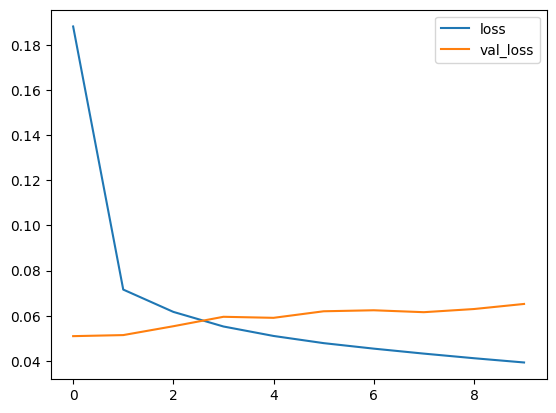

In [18]:
hist.plot()

In [19]:
predicted_value = []
gtmey_orig = []
count =0;
for x, y in p_train.take(20):
  gtmey_orig.append(y[0].numpy())
  t_pred= model.predict(x)
  predicted_value.append(t_pred[0])

1/1 [==============================] - 0s 16ms/step


<AxesSubplot:>

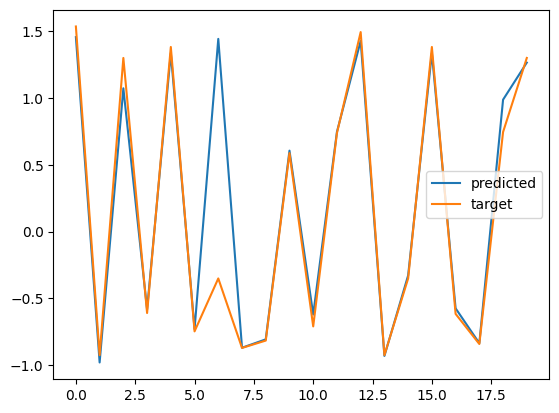

In [20]:
y_pred = [predicted_value[i][0] for i in range(len(predicted_value))]
result_gtmey = pd.DataFrame({'predicted':y_pred, 'target':gtmey_orig})
result_gtmey.plot()

In [21]:
(result_gtmey).to_csv("pizarra_glo_forecast.csv")